In [117]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
import weibull
import scipy.optimize as optimization
sys.path.append('../../..')

import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

In [118]:
%matplotlib notebook

The next cell has parameters that might change from crystal to crystal

In [119]:
# Loading in the compressed data
Segmentname = 'Segments2'
Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# Histogram accumulation
accumlist = [] # all

# Parameters for binning
Z2minforhist = 0.0
Z2maxforhist = .025
Z2offset = 0.0001
nbins_max = 8
levels = 3

Segments2_compr_flat_filt.npz


In [120]:
# # Loading in the compressed data
# Segmentname = 'Segments2'
# Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# # Histogram accumulation
# accumlist = [] # all

# # Parameters for binning
# Z2minforhist = 0.0
# Z2maxforhist = .25
# Z2offset = 0.001
# nbins_max = 8
# levels = 3

In [121]:
# Derivative names
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments2_compr_flat_filt_roughness.jpg
9
2019-07-02/case2.0 (calibration)


In [122]:
# Histogram accumulation
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50); Z2theory=Z2theory[1:] # This is for Weibull plots
print('Using levels =', levels, 'for uncertainty analysis')


Accumulating segments [0, 1, 2, 3, 4, 5, 6, 7, 8]
Plotting segments [0, 1, 2, 3, 4, 5, 6, 7, 8]
Z2 ranging from 0.0 to 0.025
Max number of bins specified is 8
Sturges rule says maxbins = 9
Using nbins =  8
Using levels = 3 for uncertainty analysis


Original =  435
4 0 109 [44 29 15  7  7  1  4]
4 1 109 [51 27 12  7  7  2  1]
4 2 109 [48 31 17  8  0  0  1]
4 3 108 [43 36 11  6  7  1  3]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.006087264123606699
statsigma =  0.07802092106356281

****Working on segment 0


<IPython.core.display.Javascript object>


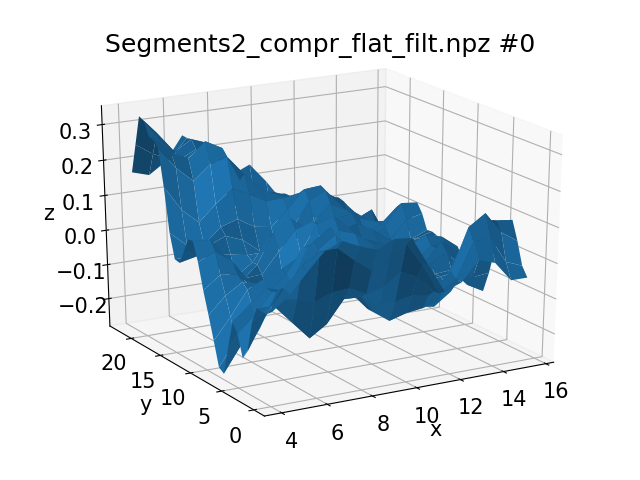

std dev of height =  0.09792631166799974
integral =  0.002754024144869216


<IPython.core.display.Javascript object>


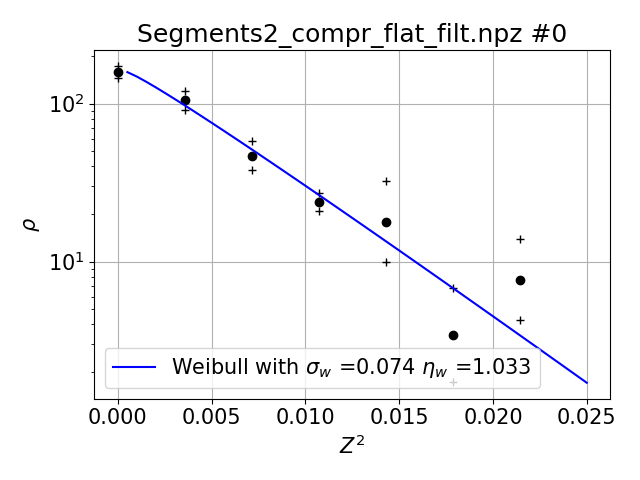

[144.70762461  91.08607311  37.78254466  20.93088518   9.93596233
   1.72052872   4.25826957]
Based on raw data: sigmaW, etaW =  0.0754918402752406 1.0553177035535377
Based on bins: sigmaW, etaW =  0.0744539095678071 1.0332132879884712
Original =  435
4 0 109 [48 25 15 11  5  2  1]
4 1 109 [48 29 15  8  2  5  0]
4 2 109 [49 33 12  7  4  1  2]
4 3 108 [44 33 15  8  3  4  0]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.005932833339361671
statsigma =  0.07702488779194469

****Working on segment 1


../../../statstuff.py:502: RuntimeWarning: invalid value encountered in power
  term2 = (Z2/sigma2W)**(etaW-1)
../../../statstuff.py:503: RuntimeWarning: invalid value encountered in power
  term3 = np.exp(-(Z2/sigma2W)**etaW)


<IPython.core.display.Javascript object>


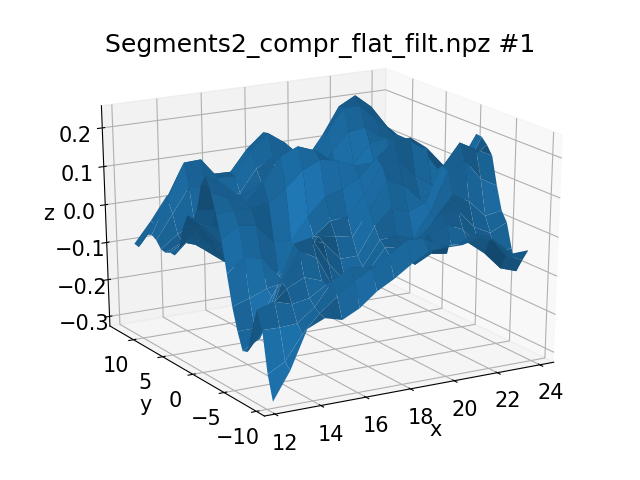

std dev of height =  0.0946837862848363
integral =  0.002772227772227772


<IPython.core.display.Javascript object>


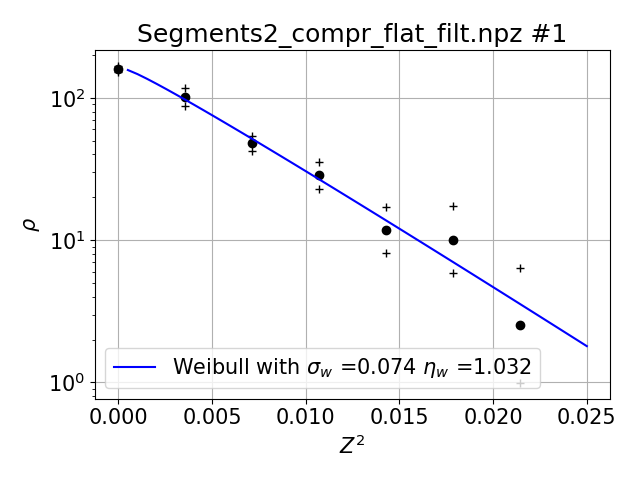

[150.43175076  87.47567812  42.54394273  22.96308233   8.15529469
   5.82683927   0.99518086]
Based on raw data: sigmaW, etaW =  0.07652093753664414 1.1124799668436793
Based on bins: sigmaW, etaW =  0.07490887091632054 1.032254565815177
Original =  435
4 0 109 [51 20 22  3  7  2  2]
4 1 109 [53 22 15 12  0  2  1]
4 2 109 [49 32 11  7  4  2  1]
4 3 108 [49 31 11  5  5  3  2]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.006041864544500131
statsigma =  0.07772943164915161

****Working on segment 2


<IPython.core.display.Javascript object>


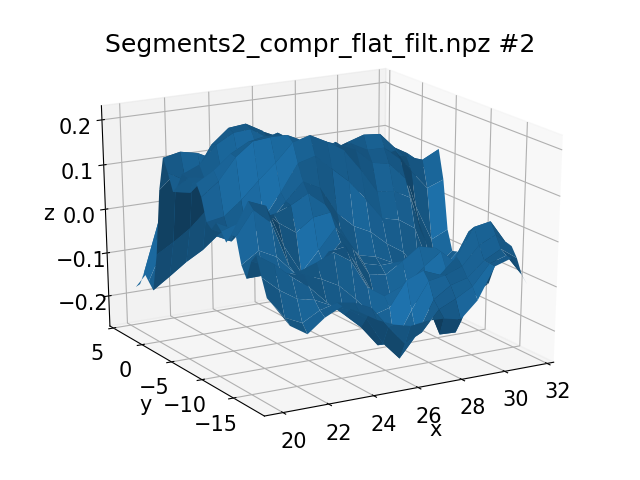

std dev of height =  0.10785526236354329
integral =  0.0026954177897574125


<IPython.core.display.Javascript object>


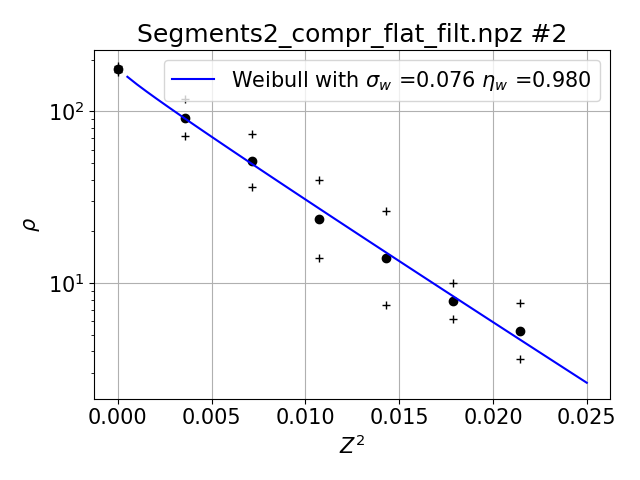

[169.0439182   71.73392445  36.28226619  13.99672775   7.42775815
   6.21466737   3.58915251]
Based on raw data: sigmaW, etaW =  0.07379406871880802 1.025045282586968
Based on bins: sigmaW, etaW =  0.07680769225015321 0.980290214461575
Original =  435
4 0 109 [49 33  9  8  3  5  0]
4 1 109 [50 29 12  6  7  3  2]
4 2 109 [51 24 18  9  2  1  3]
4 3 108 [51 26 18  7  1  1  3]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.00572434561933337
statsigma =  0.07565940535936937

****Working on segment 3


<IPython.core.display.Javascript object>


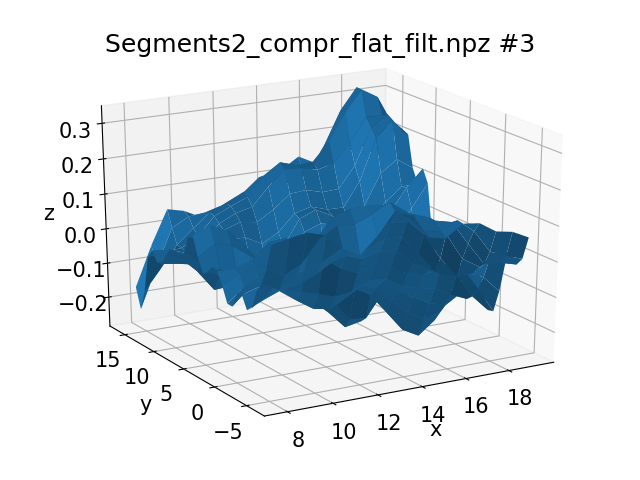

std dev of height =  0.11464330524400505
integral =  0.002705502154458071


<IPython.core.display.Javascript object>


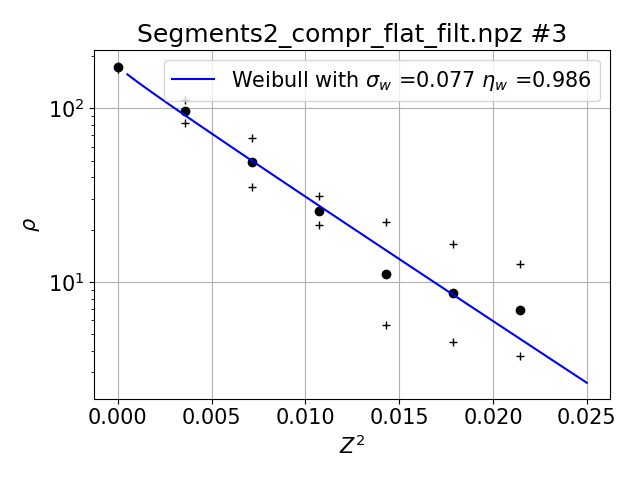

[168.51359758  82.22445508  35.43069594  21.31616044   5.65092756
   4.46460511   3.70823684]
Based on raw data: sigmaW, etaW =  0.0742657903217175 1.0281995020986396
Based on bins: sigmaW, etaW =  0.07703283267408235 0.9868231238026559
Original =  435
4 0 109 [49 24 14  9  7  3  3]
4 1 109 [48 30 13  6  6  3  1]
4 2 109 [53 21 17  7  3  4  3]
4 3 108 [50 23 12 12  4  2  4]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.0061848649708401955
statsigma =  0.07864391248431245

****Working on segment 4


<IPython.core.display.Javascript object>


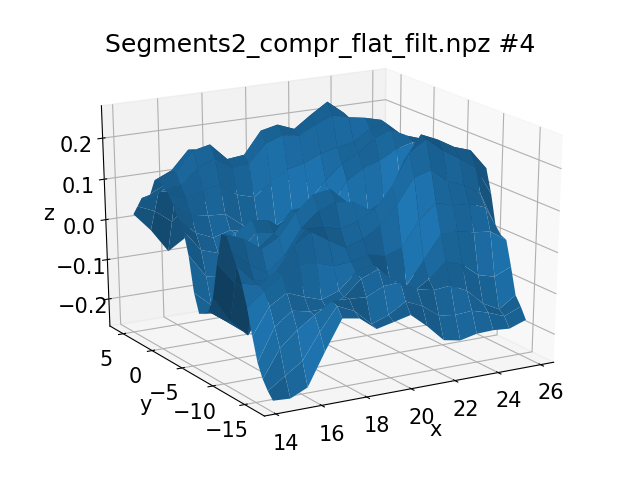

std dev of height =  0.10905499901328107
integral =  0.002697215777262181


<IPython.core.display.Javascript object>


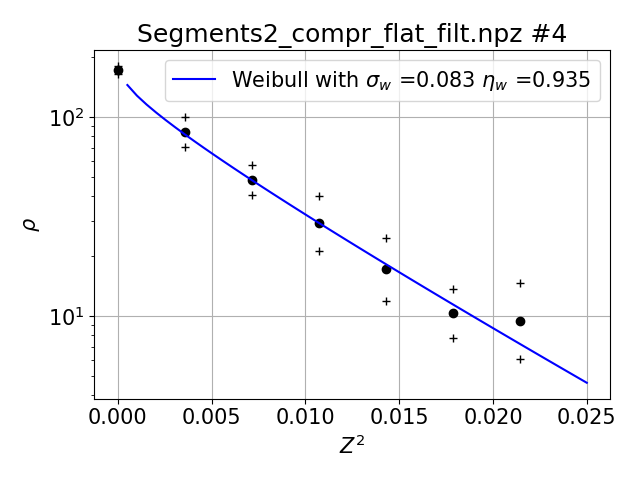

[163.54791785  70.8382269   40.63405787  21.28294114  11.95577945
   7.77767081   6.10435035]
Based on raw data: sigmaW, etaW =  0.07795607429277247 1.0362997115397259
Based on bins: sigmaW, etaW =  0.08380999920193313 0.9354659338504823
Original =  435
4 0 109 [32 25 12 14  7  7  5]
4 1 109 [30 26 17  7  5  4  6]
4 2 109 [28 18 14 18  8  8  4]
4 3 108 [32 16 23  8  5 10  6]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.010529858481234559
statsigma =  0.10261509870011605

****Working on segment 5


<IPython.core.display.Javascript object>


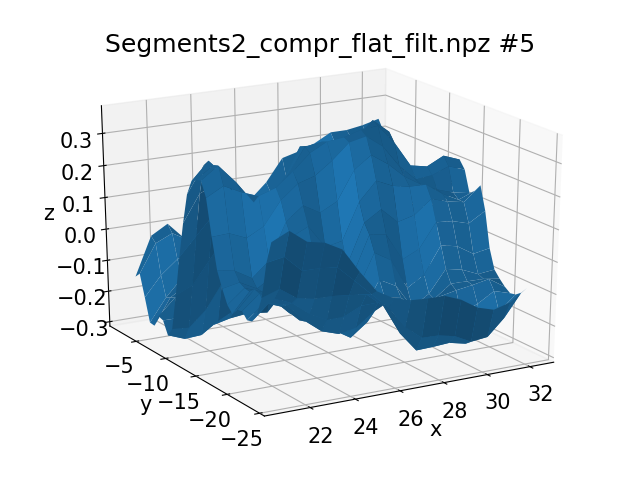

std dev of height =  0.15885950009782002
integral =  0.0029249547920433996


<IPython.core.display.Javascript object>


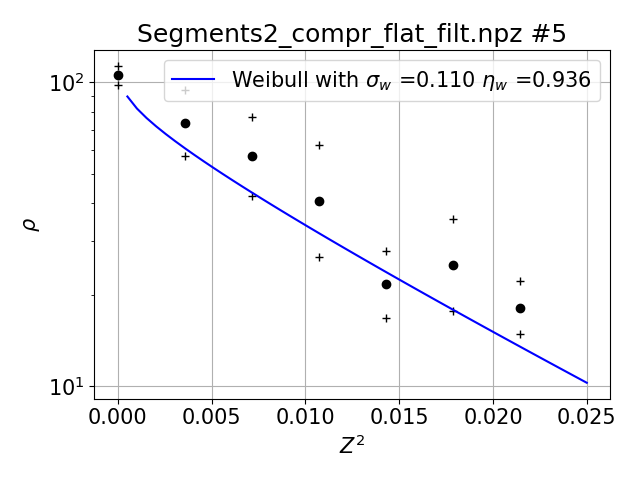

[98.18421672 57.36892666 42.33259168 26.57371045 16.79294954 17.74430938
 14.90770873]
Based on raw data: sigmaW, etaW =  0.09308044135843783 1.1525719621016492
Based on bins: sigmaW, etaW =  0.11001079716993079 0.936160330314163
Original =  435
4 0 109 [41 25 17 13  5  2  1]
4 1 109 [42 28 15  9  6  1  3]
4 2 109 [50 16 16 11  5  3  5]
4 3 108 [40 30 14 13  3  2  1]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.007283911909691274
statsigma =  0.08534583709643531

****Working on segment 6


<IPython.core.display.Javascript object>


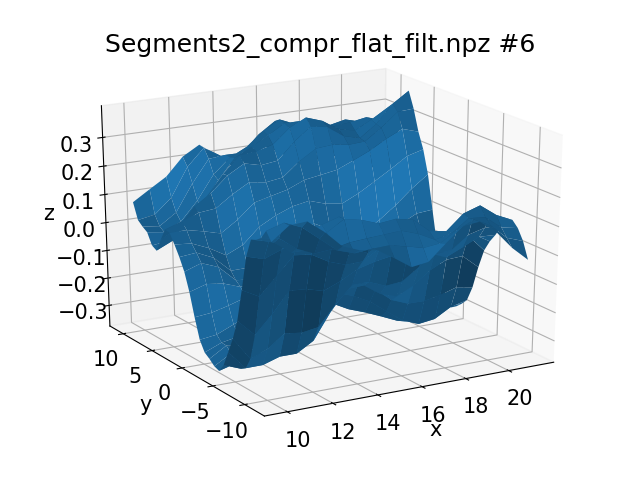

std dev of height =  0.18907211732351104
integral =  0.002787769784172662


<IPython.core.display.Javascript object>


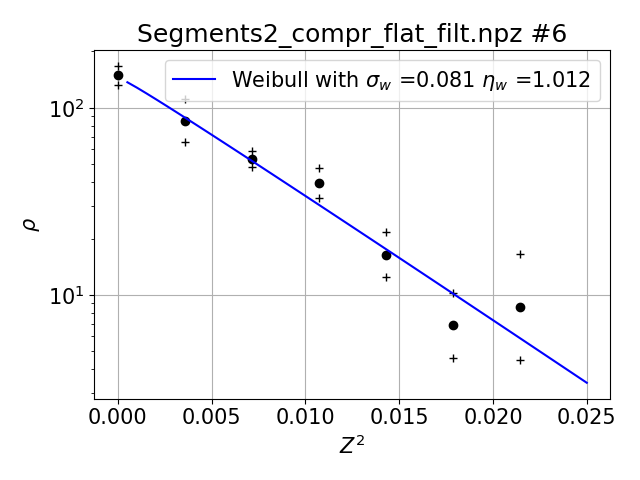

[132.0319169   65.48747852  48.47893435  32.96987731  12.39615681
   4.61609245   4.47832125]
Based on raw data: sigmaW, etaW =  0.07977141710029705 1.0821769101970613
Based on bins: sigmaW, etaW =  0.08156651766246409 1.0126876885581766
Original =  435
4 0 109 [39 27 21  5  3  4  2]
4 1 109 [39 32  8 10 10  5  2]
4 2 109 [41 26 15 11 11  0  2]
4 3 108 [43 22 13 12  9  1  3]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.007657927851940187
statsigma =  0.08750958720014732

****Working on segment 7


<IPython.core.display.Javascript object>


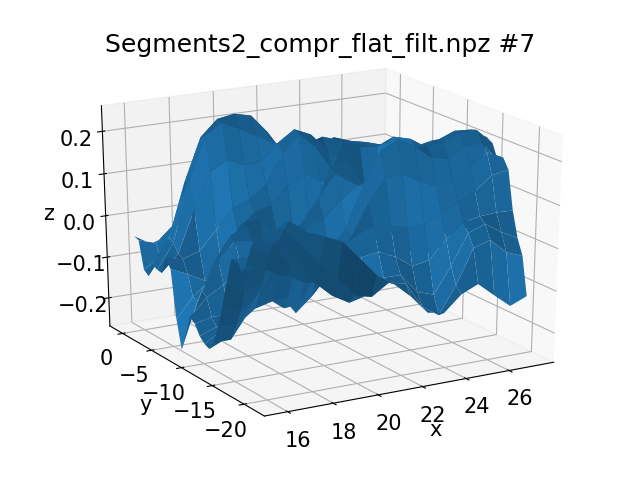

std dev of height =  0.11236120796697116
integral =  0.002837396978021979


<IPython.core.display.Javascript object>


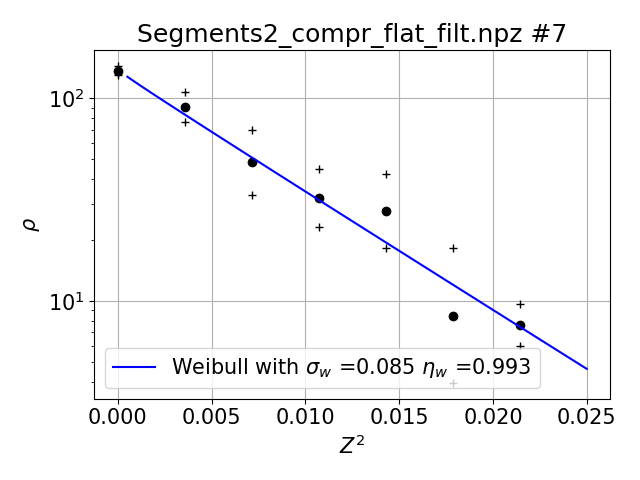

[129.86480278  76.507915    33.21947869  23.10332857  18.34810716
   3.9501023    6.01722711]
Based on raw data: sigmaW, etaW =  0.08241586823278026 1.1038802378977426
Based on bins: sigmaW, etaW =  0.08584865228115715 0.9930139260383594
Original =  435
4 0 109 [36 28 18 10  6  4  2]
4 1 109 [44 27 10  6  9  4  5]
4 2 109 [42 15 23  7 10  7  3]
4 3 108 [41 22 17  6  9  4  5]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.007881337086513835
statsigma =  0.08877689500378932

****Working on segment 8


<IPython.core.display.Javascript object>


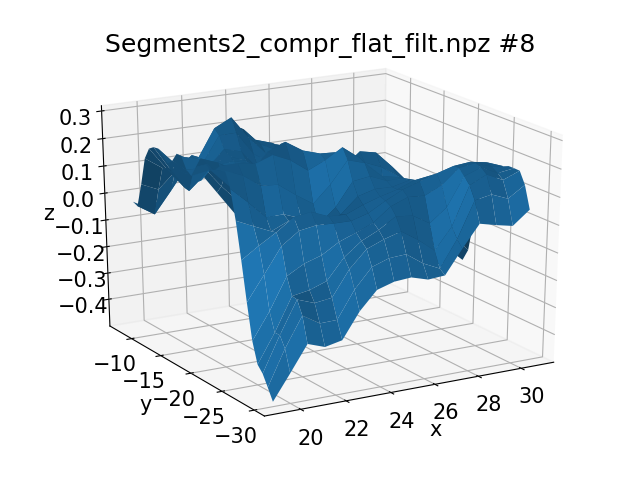

std dev of height =  0.14173537225144833
integral =  0.0028146258503401363


<IPython.core.display.Javascript object>


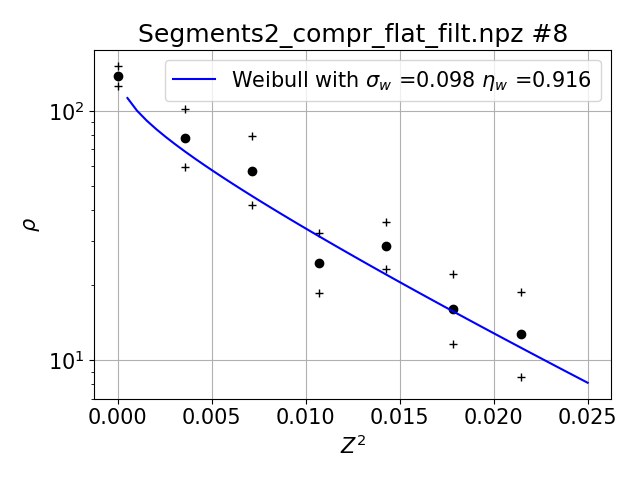

[125.30342384  59.3760766   41.7241286   18.67087902  23.10183208
  11.64966991   8.56835016]
Based on raw data: sigmaW, etaW =  0.08398125014376705 1.0107287031056305
Based on bins: sigmaW, etaW =  0.09869303913684452 0.9166466371747023


In [123]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# First-guess for Weibull fitting (sigma2W, etaW)
x0 = np.array([.1,.9])

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)

    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Reporting
        print('')
        print('****Working on segment', isegment)
        
        # Graph the surface
        fig1 = plt.figure()
        ax = fig1.add_subplot(111, projection='3d')
        ax.plot_surface(xgrid, ygrid, sollast)
        title = Flattenedfilename+' #'+str(isegment)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title(title)
        ax.view_init(azim=-120,elev=22)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho

        # Graph the probability
        plt.figure()
        plt.semilogy(bins, counts, 'ok')
        countsplus = counts+error; #print(countsplus)
        countsminus = counts**2/countsplus; print(countsminus)
        plt.semilogy(bins, countsplus, '+k')
        plt.semilogy(bins, countsminus,'+k')
        plt.title(title)
        plt.xlabel(r'$Z^{2}$')
        plt.ylabel(r'$\rho$')
        plt.grid(True)
        
        # Eliminate entries greater than a threshold (not sure if this is necessary)
        ikeep = np.argwhere(Z2flat < Z2maxforhist)
        Z2flat_new = np.squeeze(Z2flat[ikeep])

        # Attempt a best-fit based on the raw data
        analysis = weibull.Analysis(Z2flat_new)
        analysis.fit(method='mle')
        etaW = analysis.beta
        sigma2W = analysis.eta
        sigmaW = np.sqrt(sigma2W)
        print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)
        
        # Attempt a best-fit based on the bins
        errors = np.log(countsplus/counts); #print(errors)
        solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
        etaW = solution[1]
        sigma2W = solution[0]
        sigmaW = np.sqrt(sigma2W)
        print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)
        
        # Graph the best-fit probability
        myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
        plt.semilogy(Z2theory, myWeibull, 'b',label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ' $\eta_w$ =' + str(etaW)[0:5])
        plt.legend()
        
    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

In [124]:
# Sum up the accumulated information
# Naccum, Laccum = np.shape(Z2flat_list)
# Z2flat_total = np.reshape(Z2flat_list,Naccum*Laccum,1)
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
#ikeep = np.argwhere(Z2flat_total < Z2maxforhist)
#Z2flat_new = np.squeeze(Z2flat_total[ikeep])
Z2flat_new = np.squeeze(Z2flat_total)
# ikeep = np.argwhere(Z2flat_total < Z2maxforhist)
# Z2flat_new = np.squeeze(Z2flat_total[ikeep])

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; #print(countsminus)

# Attempt a best-fit based on the raw data
analysis = weibull.Analysis(Z2flat_new)
analysis.fit(method='mle')
etaW = analysis.beta
sigma2W = analysis.eta
sigmaW = np.sqrt(sigma2W)
print('Based on raw data: sigmaW, etaW = ', sigmaW, etaW)

# Attempt a best-fit based on the bins
errors = np.log(countsplus/counts); #print(errors)
solution, solutionerror = optimization.curve_fit(sts.logWeibull, bins+Z2offset, np.log(counts),x0,sigma=errors)
etaW = solution[1]
sigma2W = solution[0]
sigmaW = np.sqrt(sigma2W)
print('Based on bins: sigmaW, etaW = ', sigmaW, etaW)

Original =  435
4 0 109 [36 28 18 10  6  4  2]
4 1 109 [44 27 10  6  9  4  5]
4 2 109 [42 15 23  7 10  7  3]
4 3 108 [41 22 17  6  9  4  5]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.007881337086513835
statsigma =  0.08877689500378932
integral =  0.0028146258503401363
Based on raw data: sigmaW, etaW =  0.08346911126179632 0.9777827797384966
Based on bins: sigmaW, etaW =  0.09869303913684452 0.9166466371747023


../../../statstuff.py:502: RuntimeWarning: invalid value encountered in power
  term2 = (Z2/sigma2W)**(etaW-1)
../../../statstuff.py:503: RuntimeWarning: invalid value encountered in power
  term3 = np.exp(-(Z2/sigma2W)**etaW)


<IPython.core.display.Javascript object>


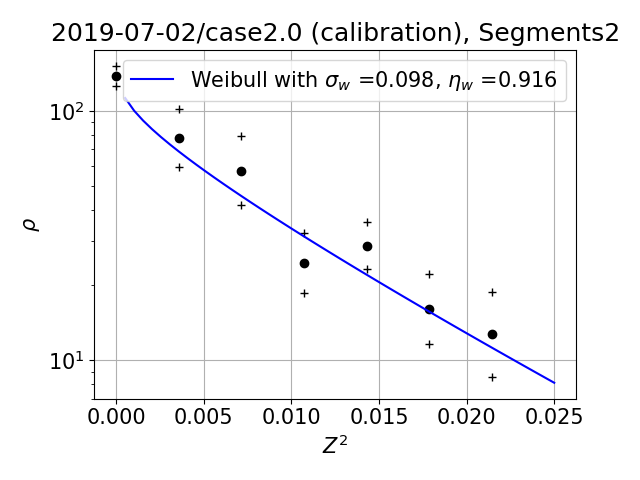

In [125]:
# Graph the probability
plt.figure()
fontsize = 15
plt.rcParams.update({'font.size': fontsize})
plt.semilogy(bins, counts, 'ok')
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(case_and_folder + ', ' + Segmentname)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)

# Graph the best-fit probability
myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
plt.semilogy(Z2theory, myWeibull, 'b', \
             label = 'Weibull with $\sigma_w$ =' + str(sigmaW)[0:5] + ', $\eta_w$ =' + str(etaW)[0:5])
plt.legend(fontsize=fontsize)

In [126]:
plt.savefig(Roughnessfilename)